# SVM


#### Kaggle competition
https://www.kaggle.com/c/titanic


### The validation metric is accuracy.

In [1]:
import pandas as pd
import numpy as np

# Import supplementary visualization code visuals.py
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('train.csv')

# Pretty display for notebooks
%matplotlib inline

def pre_proc(data):
    # ---  Pre-processing ---
    # Removing data from training
    data = data.drop(columns=['Ticket', 'Name', 'Cabin'])
    # Log-transform Fare
    skewed = ['Fare']
    data = pd.DataFrame(data = data)
    data[skewed] = data[skewed].apply(lambda x: np.log(x + 1))
    # Replacing: Male = 0 and Female = 1
    gender = {"male": 0, "female": 1}
    data = data.replace({"Sex":gender})
    # Replaces: Embarked C = 0, Q = 1, S = 2
    gate = {"C":0, "Q":1, "S":2}
    data = data.replace({"Embarked":gate})
    # Min Max Scaler (Normalization)
    scaler = MinMaxScaler()
    numerical = ['Fare', 'Pclass', 'Embarked', 'Parch', 'SibSp']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

data = pre_proc(data)    
data.head()


/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,1.0,0,22.0,0.125,0.0,0.338125,1.0
1,2,1,0.0,1,38.0,0.125,0.0,0.685892,0.0
2,3,1,1.0,1,26.0,0.000,0.0,0.350727,1.0
3,4,1,0.0,1,35.0,0.125,0.0,0.639463,1.0
4,5,0,1.0,0,35.0,0.000,0.0,0.352955,1.0


### Predict the Age of the passenger in order to fill the NaN values more accurately


In [2]:
#### Preparing the data for predicting the Age

def pred_age(data):
    #### Getting only data where the Age is not NaN
    not_nan_data = data[data['Age'].notna()]
    # Removing NaN values from other columns
    not_nan_data = not_nan_data.fillna(0)
    # Extracting features
    features_age_training = not_nan_data.drop(columns = ['Age', 'PassengerId'])
    # Extracting the Age
    age_data = not_nan_data['Age']
    
    #### Creating the model to predict the Age
    from sklearn.tree import DecisionTreeRegressor
    # Model implementation
    age_predictor = DecisionTreeRegressor(max_depth = 15, min_samples_split = 5)
    age_predictor.fit(features_age_training, age_data)

    #### Predicting the missing data of Age
    # Getting only data where the Age is NaN
    nan_data = data[data['Age'].isna()]
    # Removing NaN values from other columns
    nan_data = nan_data.fillna(0)
    # Extracting the passenger ids that have nan age
    passengerid_nan_age = nan_data['PassengerId']
    # Extracting features
    features_nan_data = nan_data.drop(columns = ['Age', 'PassengerId'])
    age_prediction = age_predictor.predict(features_nan_data)

    #### Filling out the NaN data from the Age with the predicted values 
    # Creating a np array with Id and Age of from both origin and predicted data
    origin_age = np.array(data[['PassengerId', 'Age']])
    pred_age = np.transpose(np.array([passengerid_nan_age, age_prediction]))
    # Creating a copy of age origin age data to modify it with the final values 
    final_age = origin_age
    # Creating a final age data
    for i in range(0, len(origin_age)):
        for j in range(0, len(pred_age)):
            if origin_age[i, 0] == pred_age[j, 0]:
                final_age[i, 1] = pred_age[j, 1]
    final_data = data.copy()
    # Coping the ages into the final_data Datraframe
    final_data['Age'] = final_age[:, 1]
    
    #### Final pre-processing
    # Log-transform 
    skewed = ['Age']
    final_data = pd.DataFrame(data = final_data)
    final_data[skewed] = final_data[skewed].apply(lambda x: np.log(x + 1))
    # Min Max Scaler (Normalization)
    scaler = MinMaxScaler()
    numerical = ['Age']
    final_data = pd.DataFrame(data = final_data)
    final_data[numerical] = scaler.fit_transform(final_data[numerical])
    final_data.fillna(0, inplace = True)
    return final_data

final_data = pred_age(data)

#### Creating final features for training

In [3]:
# Extracting features and survived_data
features_final = final_data.drop(columns = ['Survived', 'PassengerId'])
survived_data = final_data['Survived']
features_final.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0,0.688670,0.125,0.0,0.338125,1.0
1,0.0,1,0.819257,0.125,0.0,0.685892,0.0
2,1.0,1,0.728321,0.000,0.0,0.350727,1.0
3,0.0,1,0.799463,0.125,0.0,0.639463,1.0
4,1.0,0,0.799463,0.000,0.0,0.352955,1.0


#### Removing outliers

In [4]:
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in features_final.keys():
    # TCalculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(features_final[feature], 25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(features_final[feature], 75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(features_final[~((features_final[feature] >= Q1 - step) & (features_final[feature] <= Q3 + step))])
    outliers.append(features_final[~((features_final[feature] >= Q1 - step) & (features_final[feature] <= Q3 + step))].index)

# OPTIONAL: Select the indices for data points you wish to remove
outliers_list = []
for sublist in outliers:
    for index in sublist:
        outliers_list.append(index)
        


Data points considered outliers for the feature 'Pclass':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


Data points considered outliers for the feature 'Sex':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


Data points considered outliers for the feature 'Age':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
7,1.0,0,0.184964,0.375,0.166667,0.495832,1.0
10,1.0,1,0.311287,0.125,0.166667,0.460439,1.0
16,1.0,0,0.184964,0.500,0.166667,0.545650,0.5
24,1.0,1,0.456643,0.375,0.166667,0.495832,1.0
43,0.5,1,0.256106,0.125,0.333333,0.601092,0.0
50,1.0,0,0.427516,0.500,0.166667,0.593810,1.0
58,0.5,1,0.356374,0.125,0.333333,0.538164,1.0
63,1.0,0,0.311287,0.375,0.333333,0.538998,1.0
78,0.5,0,0.062728,0.000,0.333333,0.544984,1.0
119,1.0,1,0.184964,0.500,0.333333,0.556696,1.0


Data points considered outliers for the feature 'SibSp':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
7,1.0,0,0.184964,0.375,0.166667,0.495832,1.0
16,1.0,0,0.184964,0.500,0.166667,0.545650,0.5
24,1.0,1,0.456643,0.375,0.166667,0.495832,1.0
27,0.0,0,0.654108,0.375,0.333333,0.893450,1.0
50,1.0,0,0.427516,0.500,0.166667,0.593810,1.0
59,1.0,0,0.527784,0.625,0.333333,0.619959,1.0
63,1.0,0,0.311287,0.375,0.333333,0.538998,1.0
68,1.0,1,0.628053,0.500,0.333333,0.350727,1.0
71,1.0,1,0.613918,0.625,0.333333,0.619959,1.0
85,1.0,1,0.785328,0.375,0.000000,0.452554,1.0


Data points considered outliers for the feature 'Parch':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
7,1.0,0,0.184964,0.375,0.166667,0.495832,1.0
8,1.0,1,0.737315,0.000,0.333333,0.399934,1.0
10,1.0,1,0.311287,0.125,0.166667,0.460439,1.0
13,1.0,0,0.825518,0.125,0.833333,0.556696,1.0
16,1.0,0,0.184964,0.500,0.166667,0.545650,0.5
24,1.0,1,0.456643,0.375,0.166667,0.495832,1.0
25,1.0,1,0.819257,0.125,0.833333,0.557253,1.0
27,0.0,0,0.654108,0.375,0.333333,0.893450,1.0
43,0.5,1,0.256106,0.125,0.333333,0.601092,0.0
50,1.0,0,0.427516,0.500,0.166667,0.593810,1.0


Data points considered outliers for the feature 'Fare':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
27,0.0,0,0.654108,0.375,0.333333,0.893450,1.0
88,0.0,1,0.699194,0.375,0.333333,0.893450,1.0
118,0.0,0,0.709289,0.000,0.166667,0.883769,0.0
179,1.0,0,0.806239,0.000,0.000000,0.000000,1.0
258,0.0,1,0.799463,0.000,0.000000,1.000000,0.0
263,0.0,0,0.831624,0.000,0.000000,0.000000,1.0
271,1.0,0,0.718988,0.000,0.000000,0.000000,1.0
277,0.5,0,0.786882,0.000,0.000000,0.000000,1.0
299,0.0,1,0.885597,0.000,0.166667,0.883769,0.0
302,1.0,0,0.654108,0.000,0.000000,0.000000,1.0


Data points considered outliers for the feature 'Embarked':


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [5]:
outliers_list.sort()

repetitions = []
for element in outliers_list:
    count = outliers_list.count(element)
    repetitions.append((element, count))

# remove elements considered outliers for 3 or more features
removal_list = []
for element in repetitions:
    if element[1] >= 3 and (element[0] not in removal_list):
        removal_list.append(element[0])

removal_list
# Remove the outliers, if any were specified
good_data = features_final.drop(features_final.index[removal_list]).reset_index(drop = True)
survived_data = survived_data.drop(survived_data.index[removal_list]).reset_index(drop = True)

### PCA Visualization

In [8]:
from sklearn.decomposition import PCA

# The number of components must be min(n_samples, n_features)
n_components = 3

pca = PCA(n_components = n_components)
pca.fit(good_data)

print(pca.explained_variance_ratio_)

[0.4036589  0.28225143 0.21880776]


In [10]:
reduced_data = pca.transform(good_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3
0,-0.547584,-0.150933,0.010851
1,1.112693,0.403733,0.258857
2,0.251517,-0.723016,-0.050711
3,0.759664,0.007532,-0.588644
4,-0.548281,-0.131306,0.003216


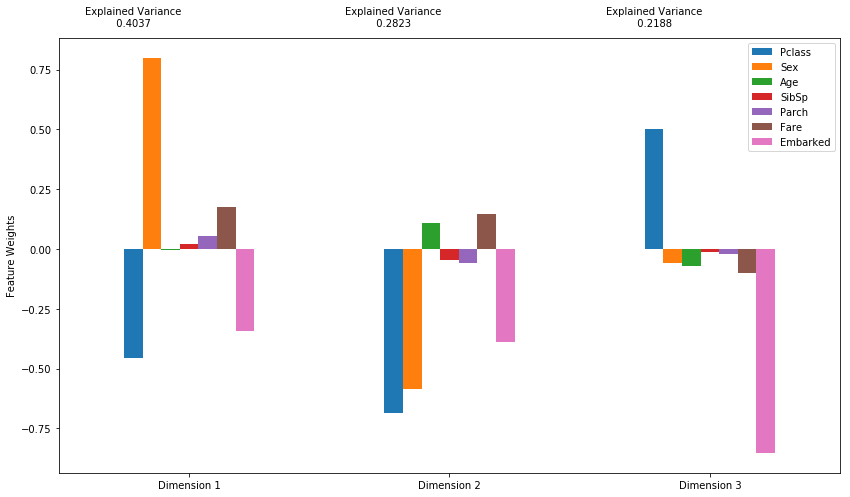

In [11]:
import visuals as vs
pca_results = vs.pca_results(good_data, pca)

<Figure size 1440x1440 with 0 Axes>

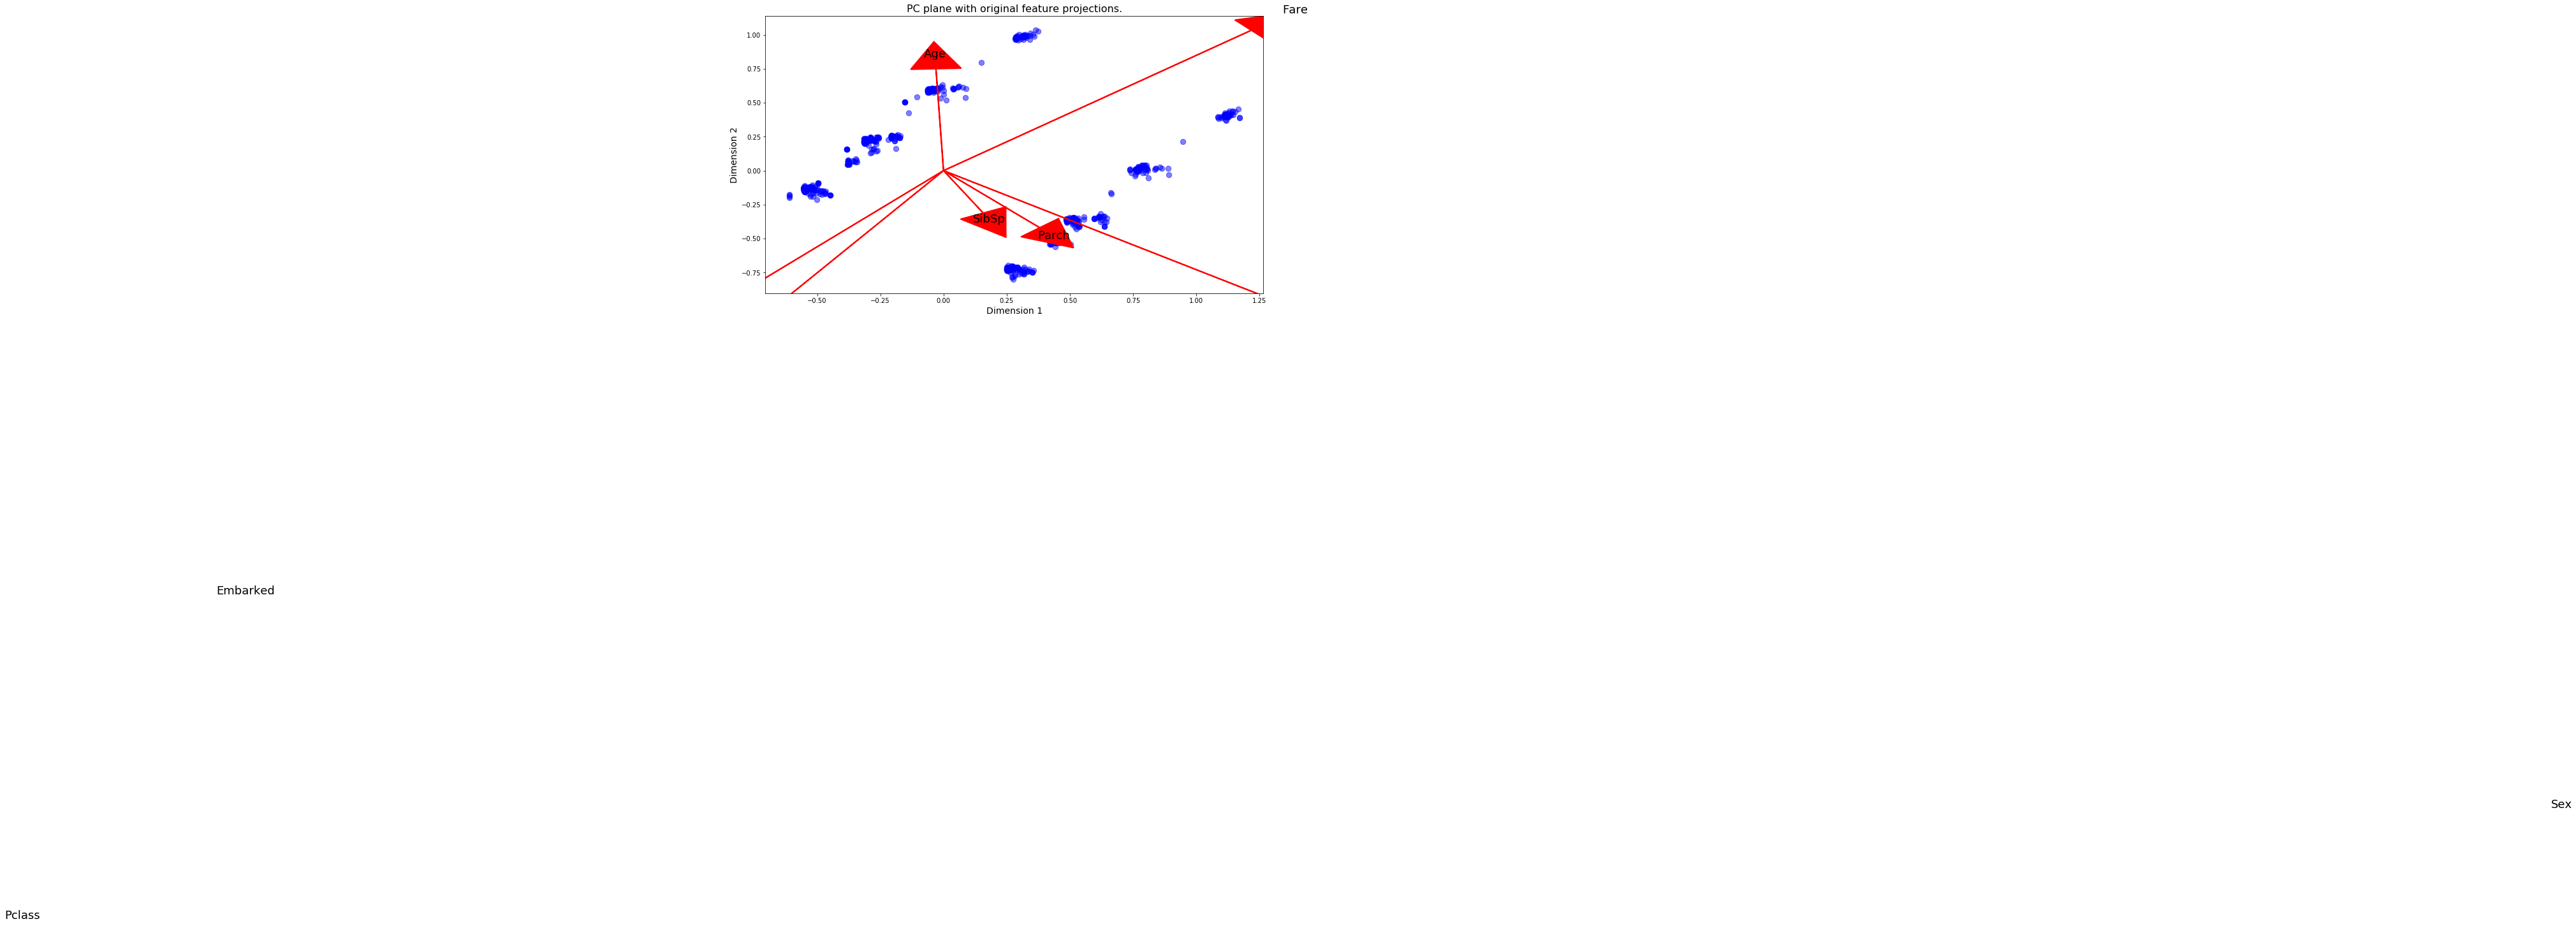

<Figure size 1440x1440 with 0 Axes>

In [12]:
features_final# Visualizing the biplot
vs.biplot(good_data, reduced_data, pca)
plt.figure(figsize = (20, 20))

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(reduced_data, survived_data,
                                                    test_size = 0.2, random_state = 33 )

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scr = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(scr))

Accuracy score: 0.7931034482758621


/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit

cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 33)
scorer = make_scorer(accuracy_score)
parameters = {'C':[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], 'kernel': ['rbf', 'poly'],'degree': range(1,7)}
model = SVC()

grid_obj = GridSearchCV(model, parameters, scoring = scorer, cv = cv_sets)
grid_fit = grid_obj.fit(X_train, y_train)

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/svm/

In [16]:
best_clf = grid_fit.best_estimator_

y_pred_train = best_clf.predict(X_train)
train_scr = accuracy_score(y_train, y_pred_train)
y_pred_test = best_clf.predict(X_test)
test_scr = accuracy_score(y_test, y_pred)

print("Train accuracy score: {}".format(train_scr))
print("Test accuracy score: {}".format(test_scr))

print("Classifier: ")
print(best_clf)

Train accuracy score: 0.8175287356321839
Test accuracy score: 0.7931034482758621
Classifier: 
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


#### Visualizing the results

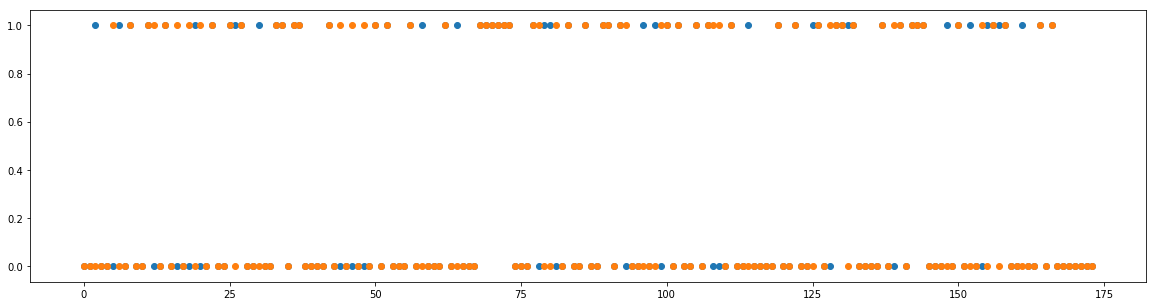

In [17]:
plt.figure(figsize=(20, 5))
plt.scatter(range(0, y_test.shape[0]), y_test)
plt.scatter(range(0, y_pred.shape[0]), y_pred)


### Using the model to predict test data

In [20]:
# --- Final prediction with test_data ---
test_data = pd.read_csv("test.csv")

# ---  Pre-processing ---
test_data = pre_proc(test_data)

#### Predicting the missing data of Age
test_data = pred_age(test_data)
test_data.head()

# Preparing features
passengerid = test_data['PassengerId'] 
features_final = test_data.drop(columns = ['PassengerId'])
features_final.head()

# PCA Transform
reduced_data = pca.transform(features_final)

/home/yuri/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [21]:
y_pred_test = best_clf.predict(reduced_data)

submission = pd.DataFrame({'PassengerId':passengerid, 'Survived':y_pred_test})

import datetime
date = datetime.date.today()
filename = "titanic_submission_" + str(date.day) + "-" + str(date.month) + "-" + str(date.year) + ".csv"
submission.to_csv(filename, index = False)
print("saved file: " + filename)

saved file: titanic_submission_22-7-2019.csv
